In [21]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2
from glob import glob

import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D
from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, concatenate, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
mask_files = sorted(glob('./brainMRI/lgg-mri-segmentation/kaggle_3m/*/*_mask*'))
train_files = [file.replace('_mask', '') for file in mask_files]

In [25]:
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "diagnosis":[diagnosis(x) for x in mask_files]})
df.head()

,image_path,mask_path,diagnosis
0,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,0
1,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,1
2,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,1
3,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,1
4,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,./brainMRI/lgg-mri-segmentation/kaggle_3m/TCGA...,1


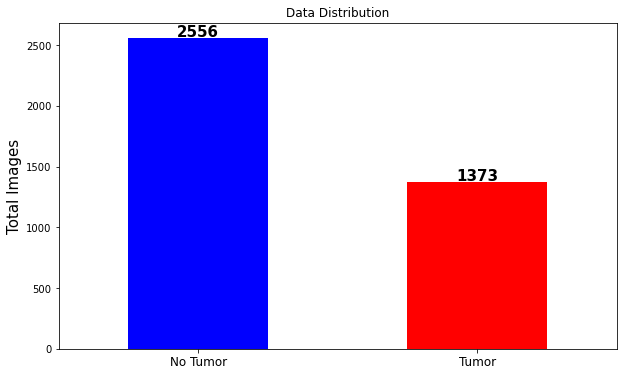

In [26]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

In [28]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.15)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2838, 3)
(501, 3)
(590, 3)


In [29]:

def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "image_path",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask_path",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255.
    mask = mask / 255.
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)



In [30]:
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [32]:
# Set parameters
EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 1e-4

# FINs Training

How FINs are trained by segments in this section

In [11]:
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
import SimpleITK as sitk

In [12]:
# convert rgb to grayscale
def rgb2gray(rgb):
    """Convert RGB image to grayscale."""
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

def setup_extractor():
    """Setup and return a radiomics feature extractor with specified features enabled."""
    extractor = RadiomicsFeatureExtractor()
    extractor.disableAllFeatures()
    extractor.enableFeaturesByName(firstorder=['Skewness'])
    extractor.enableFeaturesByName(glrlm=['GrayLevelVariance'])
    extractor.enableFeaturesByName(glcm=['Autocorrelation', 'ClusterShade', 'DifferenceEntropy'])
    extractor.enableFeaturesByName(glszm=['SizeZoneNonUniformity'])
    return extractor

def extract_features(files):

    input_array = []
    features = {name: [] for name in ['ClusterShade', 'Skewness', 'GrayLevelVariance', 'Autocorrelation', 'DifferenceEntropy', 'SizeZoneNonUniformity']}
    extractor = setup_extractor()

    for file_path in files:
        im = sitk.ReadImage(file_path)
        im_array = sitk.GetArrayFromImage(im)
        grayscale_im = rgb2gray(im_array).reshape(256, 16, 16, 1)

        # Segment wise feature collection
        segment_features = {name: [] for name in features}
        
        for segment in grayscale_im:
            segment_image = sitk.GetImageFromArray(np.squeeze(segment))
            mask_array = np.ones(segment_image.GetSize()[::-1])
            mask = sitk.GetImageFromArray(mask_array)
            mask.CopyInformation(segment_image)

            extracted = extractor.execute(segment_image, mask)
            for name in features:
                key = f'original_glcm_{name}' if name in ['ClusterShade', 'Autocorrelation', 'DifferenceEntropy'] else f'original_{name.lower()}'
                segment_features[name].append(extracted[key])

        for name in features:
            features[name].append(segment_features[name])

        input_array.append(grayscale_im)

    # Converting lists to numpy arrays and reshaping
    input_array = np.array(input_array)
    feature_arrays = {name: np.array(vals).reshape(-1, 256, 1) for name, vals in features.items()}
    return input_array, feature_arrays

# Example usage
files = ['path_to_image1.png', 'path_to_image2.png']  # List of image files
input_images, extracted_features = extract_features(files)

# Accessing specific features
o1 = extracted_features['ClusterShade']
o2 = extracted_features['Skewness']
o3 = extracted_features['GrayLevelVariance']
o4 = extracted_features['Autocorrelation']
o5 = extracted_features['DifferenceEntropy']
o6 = extracted_features['SizeZoneNonUniformity']

#U-Net with FINs

In [38]:
def load_and_prepare_models():
    models = {
            'briCS': 'briCS.h5',
            'briSkew': 'briSkew.h5',
            'briGrayLevelVariance': 'briGrayLevelVariance.h5',
            'briAuto': 'briAuto.h5',
            'briDE': 'briDE.h5',
            'briSZNU': 'briSZNU.h5'
        }
    loaded_models = {name: load_model(path) for name, path in models.items()}
    return loaded_models


def unetFIN(input_size=(256, 256, 3)):
    
    models = load_and_prepare_models()
    inputs = Input(input_size)
    
    # Use pre-trained models to process inputs
    l1 = models['briCS'](inputs)
    l2 = models['briSkew'](inputs)
    l3 = models['briGrayLevelVariance'](inputs)
    l4 = models['briAuto'](inputs)
    l5 = models['briDE'](inputs)
    l6 = models['briSZNU'](inputs)

    # U-Net's first layer
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)
    
    reshaped_and_upsampled = [keras.layers.UpSampling2D(size=(8,8))(keras.layers.Reshape([16,16,1])(model_output)) for model_output in [l1, l2, l3, l4, l5, l6]]
    # Concatenate all model outputs with the first pooling layer of U-Net
    concatenated_outputs = concatenate(reshaped_and_upsampled + [pool1], axis=3)
    norm_outputs = BatchNormalization(axis=3)(concatenated_outputs)
    reshaped_output = keras.layers.Reshape([128, 128, 70])(norm_outputs)
    
    conv2 = Conv2D(128, (3, 3), padding='same')(reshaped_output)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)
    
    return Model(inputs=[inputs], outputs=[conv10])
    

In [39]:
# Set parameters
EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 1e-4
IMAGE_SIZE = (256, 256)

In [40]:
train_generator_args = dict(rotation_range=0.1,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=IMAGE_SIZE)
    
val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
    
model = unetFIN(input_size=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))



opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[iou, dice_coef])



filename='UnetFINsGG.csv'

callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
            EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=15), tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)]

historyFIN = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2838 validated image filenames.
Found 2838 validated image filenames.
Epoch 1/50
89/88 [==============================] - ETA: 0s - loss: 1.0408 - iou: 0.0667 - dice_coef: 0.1218Found 501 validated image filenames.
Found 501 validated image filenames.
88/88 [==============================] - 48s 508ms/step - loss: 1.0408 - iou: 0.0667 - dice_coef: 0.1218 - val_loss: 1.4522 - val_iou: 0.0098 - val_dice_coef: 0.0195 - lr: 1.0000e-04
Epoch 2/50
88/88 [==============================] - 44s 499ms/step - loss: 0.8253 - iou: 0.1397 - dice_coef: 0.2430 - val_loss: 1.1834 - val_iou: 0.0115 - val_dice_coef: 0.0227 - lr: 1.0000e-04
Epoch 3/50
88/88 [==============================] - 44s 499ms/step - loss: 0.7469 - iou: 0.1840 - dice_coef: 0.3073 - val_loss: 1.0689 - val_iou: 0.0083 - val_dice_coef: 0.0165 - lr: 1.0000e-04
Epoch 4/50
88/88 [==============================] - 45s 503ms/step - loss: 0.6743 - iou: 0.2307 - dice_coef: 0.3704 - val_loss: 1.0192 - val_iou: 0.0198 - val_dice_coef: 0

Epoch 41/50
88/88 [==============================] - 44s 492ms/step - loss: 0.1514 - iou: 0.7605 - dice_coef: 0.8616 - val_loss: 0.2033 - val_iou: 0.6944 - val_dice_coef: 0.8132 - lr: 1.0000e-05
Epoch 42/50
88/88 [==============================] - 44s 493ms/step - loss: 0.1526 - iou: 0.7598 - dice_coef: 0.8603 - val_loss: 0.1579 - val_iou: 0.7472 - val_dice_coef: 0.8538 - lr: 1.0000e-05
Epoch 43/50
88/88 [==============================] - 44s 493ms/step - loss: 0.1515 - iou: 0.7597 - dice_coef: 0.8613 - val_loss: 0.1595 - val_iou: 0.7458 - val_dice_coef: 0.8526 - lr: 1.0000e-05
Epoch 44/50
88/88 [==============================] - 44s 493ms/step - loss: 0.1530 - iou: 0.7595 - dice_coef: 0.8602 - val_loss: 0.1723 - val_iou: 0.7290 - val_dice_coef: 0.8406 - lr: 1.0000e-05
Epoch 45/50
89/88 [==============================] - ETA: 0s - loss: 0.1452 - iou: 0.7683 - dice_coef: 0.8673
Epoch 45: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
88/88 [==========================

Text(0.5, 1.0, 'Dice Coef')

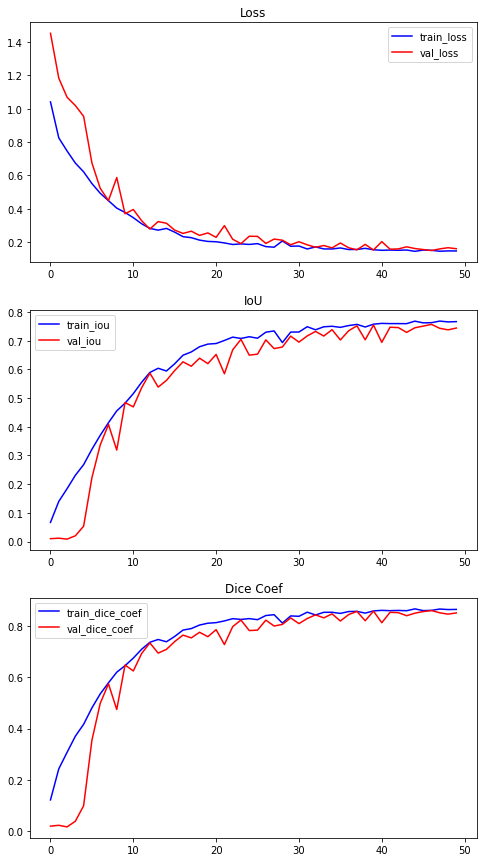

In [41]:
plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
plt.plot(historyFIN.history['loss'], 'b-', label='train_loss')
plt.plot(historyFIN.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.title('Loss')

plt.subplot(3,1,2)
plt.plot(historyFIN.history['iou'], 'b-', label='train_iou')
plt.plot(historyFIN.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.title('IoU')

plt.subplot(3,1,3)
plt.plot(historyFIN.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(historyFIN.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.title('Dice Coef')

In [42]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=IMAGE_SIZE)
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 590 validated image filenames.
Found 590 validated image filenames.
18/18 [==============================] - 3s 149ms/step - loss: 0.1593 - iou: 0.7444 - dice_coef: 0.8505
Test IOU:  0.7443687319755554
Test Dice Coefficent:  0.8505464792251587
